# Telecom X – Parte 2: Predicción de Cancelación (Churn)

Desarrollar modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios. La empresa quiere anticiparse al problema de la cancelación, y te corresponde a ti construir un pipeline robusto para esta etapa inicial de modelado.

Objetivos del Desafío

* Preparar los datos para el modelado (tratamiento, codificación, normalización).
* Realizar análisis de correlación y selección de variables.
* Entrenar dos o más modelos de clasificación.
* Evaluar el rendimiento de los modelos con métricas.
* Interpretar los resultados, incluyendo la importancia de las variables.
* Crear una conclusión estratégica señalando los principales factores que influyen en la cancelación.

## Preparación de los Datos

In [ ]:
#Importar librerias a usar
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier # Import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [ ]:
# Cargar datos tratados en la Parte 1
url = "https://raw.githubusercontent.com/28Rene13/ChallengeTelecomX2/main/datos_tratados.csv"
df = pd.read_csv(url)
df.head()

,ID_Cliente,Churn,Genero,EsAdultoMayor,TienePareja,TieneDependientes,MesesDeAntiguedad,ServicioTelefono,MultiplesLineasTelefono,TipoInternet,...,TelevisionPorCable,StreamingPeliculas,TipoContrato,FacturaElectronica,MetodoDePago,FacturaMensual,FacturaTotal,Cuentas_Diarias,RiesgoChurn,TotalServicios
0,0002-ORFBO,0,Female,0,1,1,9,1,No,DSL,...,1,0,One year,1,Mailed check,65.6,593.30,2.186667,Bajo Riesgo,2
1,0003-MKNFE,0,Male,0,0,0,9,1,Yes,DSL,...,0,1,Month-to-month,0,Mailed check,59.9,542.40,1.996667,Bajo Riesgo,1
2,0004-TLHLJ,1,Male,0,0,0,4,1,No,Fiber optic,...,0,0,Month-to-month,1,Electronic check,73.9,280.85,2.463333,Bajo Riesgo,1
3,0011-IGKFF,1,Male,1,1,0,13,1,No,Fiber optic,...,1,1,Month-to-month,1,Electronic check,98.0,1237.85,3.266667,Bajo Riesgo,3
4,0013-EXCHZ,1,Female,1,1,0,3,1,No,Fiber optic,...,1,0,Month-to-month,1,Mailed check,83.9,267.40,2.796667,Bajo Riesgo,2


In [ ]:
# Eliminar columnas irrelevantes
df2 = df.drop(columns=['ID_Cliente'])
df2.head()

,Churn,Genero,EsAdultoMayor,TienePareja,TieneDependientes,MesesDeAntiguedad,ServicioTelefono,MultiplesLineasTelefono,TipoInternet,SeguridadEnLinea,...,TelevisionPorCable,StreamingPeliculas,TipoContrato,FacturaElectronica,MetodoDePago,FacturaMensual,FacturaTotal,Cuentas_Diarias,RiesgoChurn,TotalServicios
0,0,Female,0,1,1,9,1,No,DSL,No,...,1,0,One year,1,Mailed check,65.6,593.30,2.186667,Bajo Riesgo,2
1,0,Male,0,0,0,9,1,Yes,DSL,No,...,0,1,Month-to-month,0,Mailed check,59.9,542.40,1.996667,Bajo Riesgo,1
2,1,Male,0,0,0,4,1,No,Fiber optic,No,...,0,0,Month-to-month,1,Electronic check,73.9,280.85,2.463333,Bajo Riesgo,1
3,1,Male,1,1,0,13,1,No,Fiber optic,No,...,1,1,Month-to-month,1,Electronic check,98.0,1237.85,3.266667,Bajo Riesgo,3
4,1,Female,1,1,0,3,1,No,Fiber optic,No,...,1,0,Month-to-month,1,Mailed check,83.9,267.40,2.796667,Bajo Riesgo,2


In [ ]:
# Identificar columnas categóricas y numéricas
categorical_cols = df2.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df2.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('Churn')  # Excluir la variable objetivo

print("\nVariables categóricas:", categorical_cols)
print("Variables numéricas:", numerical_cols)


Variables categóricas: ['Genero', 'MultiplesLineasTelefono', 'TipoInternet', 'SeguridadEnLinea', 'RespaldoEnLinea', 'TipoContrato', 'MetodoDePago', 'RiesgoChurn']
Variables numéricas: ['EsAdultoMayor', 'TienePareja', 'TieneDependientes', 'MesesDeAntiguedad', 'ServicioTelefono', 'ProteccionDispositivo', 'SoporteTecnico', 'TelevisionPorCable', 'StreamingPeliculas', 'FacturaElectronica', 'FacturaMensual', 'FacturaTotal', 'Cuentas_Diarias', 'TotalServicios']


In [ ]:
# Configurar el transformador para preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ])

# Aplicar la transformación
X = df2.drop(columns=['Churn'])
y = df2['Churn']

# Dividir datos antes de balanceo para evitar data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


Distribución original de Churn:
Churn
0    73.463013
1    26.536987
Name: proportion, dtype: float64


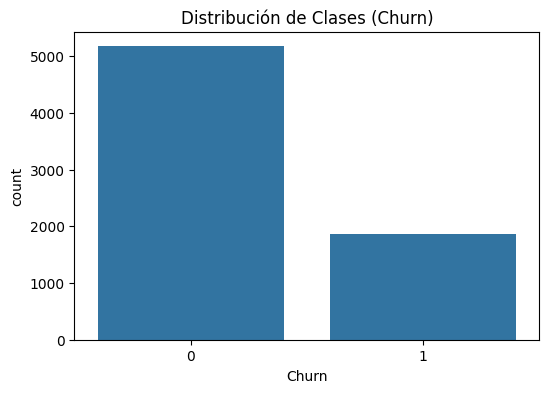

In [ ]:
#Verificación de la Proporción de Churn

# Proporción original
print("\nDistribución original de Churn:")
print(y.value_counts(normalize=True) * 100)

# Visualización
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Distribución de Clases (Churn)')
plt.show()


Distribución después de SMOTE:
Churn
0    50.0
1    50.0
Name: proportion, dtype: float64


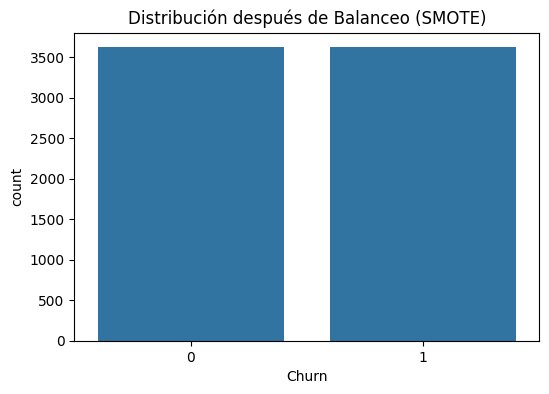

In [ ]:
#Balanceo de Clases

#Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(
    pd.DataFrame(preprocessor.fit_transform(X_train)),
    y_train
)

# Proporción después del balanceo
print("\nDistribución después de SMOTE:")
print(pd.Series(y_train_res).value_counts(normalize=True) * 100)

plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_res)
plt.title('Distribución después de Balanceo (SMOTE)')
plt.show()

In [ ]:

# Preprocesador para modelos que NO requieren escalamiento
preprocessor_no_scale = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Mantener numéricas sin escalar
)

print("\nPreprocesamiento completado:")
print("- Variables numéricas estandarizadas para modelos sensibles a escala")
print("- Variables categóricas codificadas con One-Hot Encoding")
print("- Opción de preprocesamiento sin escalamiento para modelos basados en árboles")


Preprocesamiento completado:
- Variables numéricas estandarizadas para modelos sensibles a escala
- Variables categóricas codificadas con One-Hot Encoding
- Opción de preprocesamiento sin escalamiento para modelos basados en árboles


In [ ]:
# Guardar nombres de características para análisis posterior después de de one-hot encoding

cat_encoder = preprocessor.named_transformers_['cat']
feature_names = numerical_cols + list(cat_encoder.get_feature_names_out(categorical_cols))

print("\nNombres de características después de preprocesamiento:")
print(feature_names[:10])  # Mostrar solo las primeras 10



Nombres de características después de preprocesamiento:
['EsAdultoMayor', 'TienePareja', 'TieneDependientes', 'MesesDeAntiguedad', 'ServicioTelefono', 'ProteccionDispositivo', 'SoporteTecnico', 'TelevisionPorCable', 'StreamingPeliculas', 'FacturaElectronica']


## Correlación y Selección de Variables

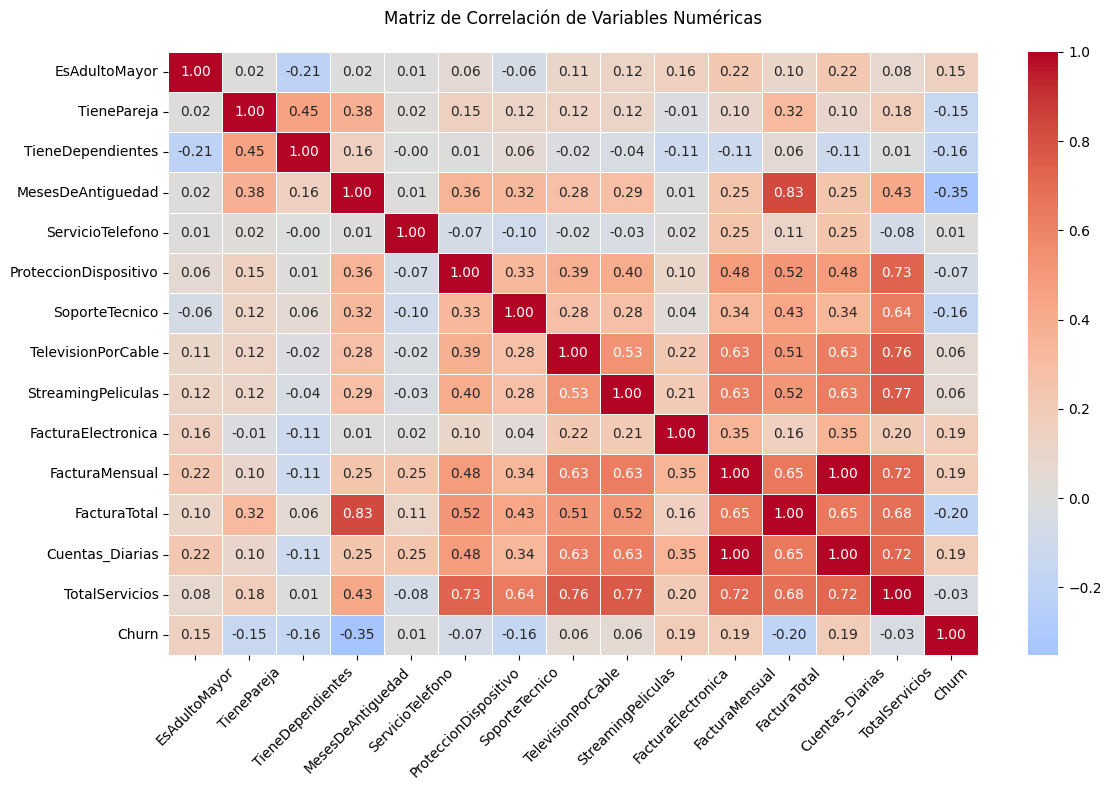

In [ ]:

#Correlación con Churn: Variables con mayor correlación (positiva o negativa) son candidatas clave.
#Multicolinealidad: Pares de variables independientes altamente correlacionadas (>0.8) podrían causar problemas en modelos lineales.

# Seleccionar solo variables numéricas (incluyendo Churn)
numeric_features = numerical_cols + ['Churn']
corr_matrix = df2[numeric_features].corr()

# Visualizar matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas', pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

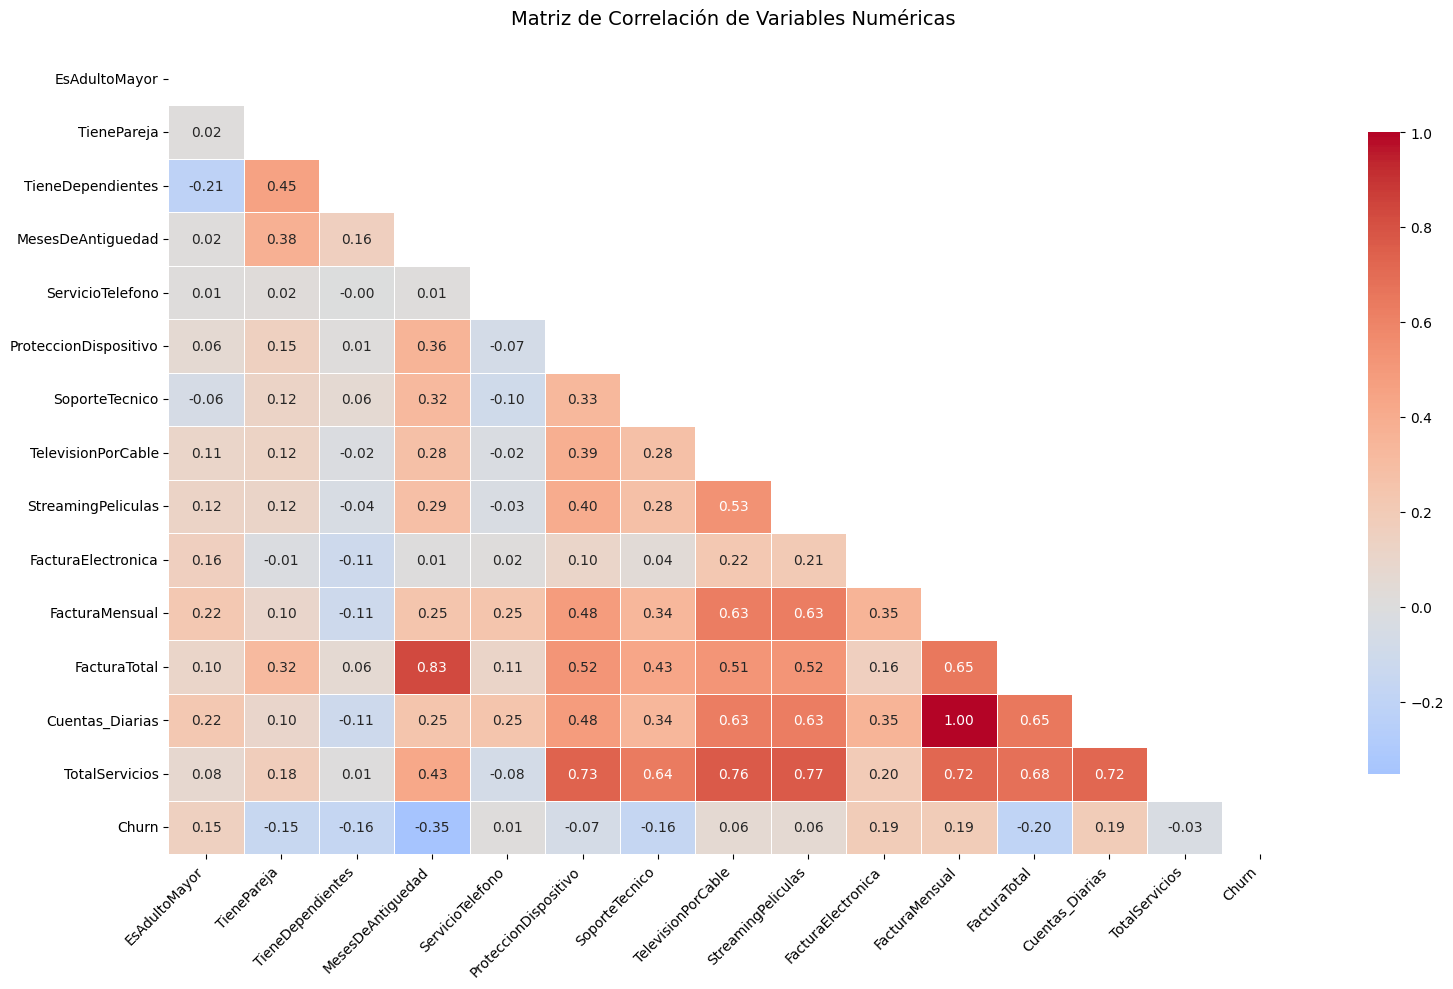


Variables más correlacionadas con Churn:
Churn                 1.000000
MesesDeAntiguedad     0.352229
FacturaTotal          0.198324
FacturaMensual        0.193356
Cuentas_Diarias       0.193356
FacturaElectronica    0.191825
Name: Churn, dtype: float64


In [ ]:
plt.figure(figsize=(16, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, fmt=".2f",
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación de Variables Numéricas', pad=20, fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Top 5 correlaciones con Churn
print("\nVariables más correlacionadas con Churn:")
print(corr_matrix['Churn'].abs().sort_values(ascending=False).head(6))

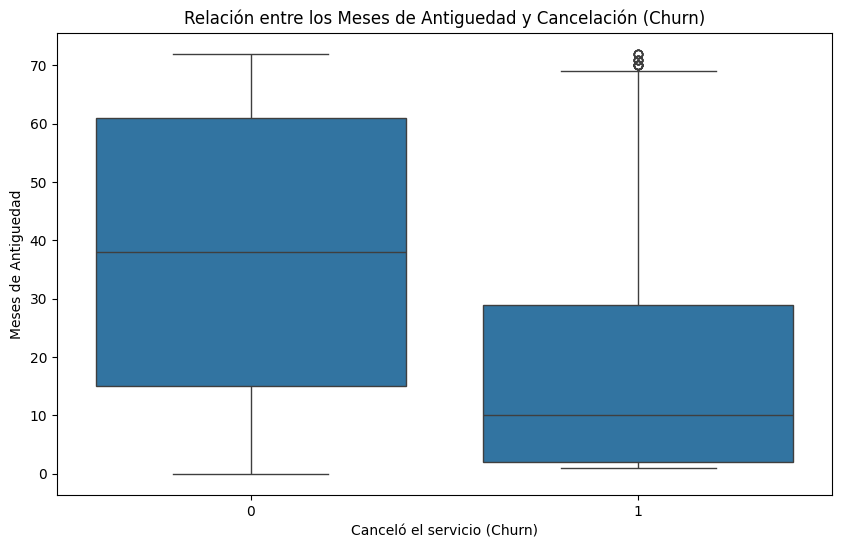


Estadísticas descriptivas de Meses de Antiguedad por grupo Churn:
        count       mean        std  min   25%   50%   75%   max
Churn                                                           
0      5174.0  37.569965  24.113777  0.0  15.0  38.0  61.0  72.0
1      1869.0  17.979133  19.531123  1.0   2.0  10.0  29.0  72.0


In [ ]:
#Meses de Antiguedad vs Cancelación(Churn)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='MesesDeAntiguedad', data=df2)
plt.title('Relación entre los Meses de Antiguedad y Cancelación (Churn)')
plt.xlabel('Canceló el servicio (Churn)')
plt.ylabel('Meses de Antiguedad')
plt.show()

# Análisis estadístico
print("\nEstadísticas descriptivas de Meses de Antiguedad por grupo Churn:")
print(df2.groupby('Churn')['MesesDeAntiguedad'].describe())

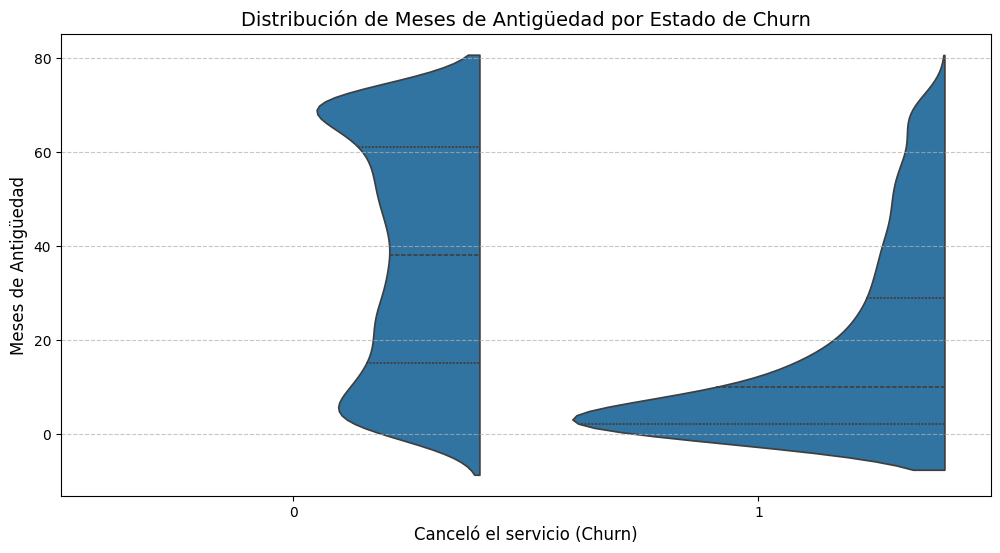

/tmp/ipython-input-13-3960047692.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_quintile = df2.groupby('QuintilAntiguedad')['Churn'].mean().reset_index()
/tmp/ipython-input-13-3960047692.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='QuintilAntiguedad', y='Churn', data=churn_by_quintile, palette="Blues_d")


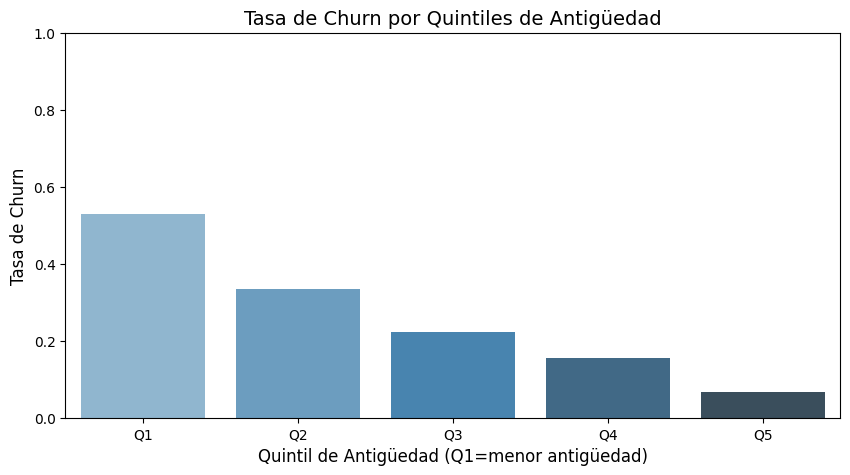

In [ ]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='Churn', y='MesesDeAntiguedad', data=df2, split=True, inner="quartile")
plt.title('Distribución de Meses de Antigüedad por Estado de Churn', fontsize=14)
plt.xlabel('Canceló el servicio (Churn)', fontsize=12)
plt.ylabel('Meses de Antigüedad', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Análisis por quintiles
df2['QuintilAntiguedad'] = pd.qcut(df2['MesesDeAntiguedad'], 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], duplicates='drop')
churn_by_quintile = df2.groupby('QuintilAntiguedad')['Churn'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='QuintilAntiguedad', y='Churn', data=churn_by_quintile, palette="Blues_d")
plt.title('Tasa de Churn por Quintiles de Antigüedad', fontsize=14)
plt.xlabel('Quintil de Antigüedad (Q1=menor antigüedad)', fontsize=12)
plt.ylabel('Tasa de Churn', fontsize=12)
plt.ylim(0, 1)
plt.show()

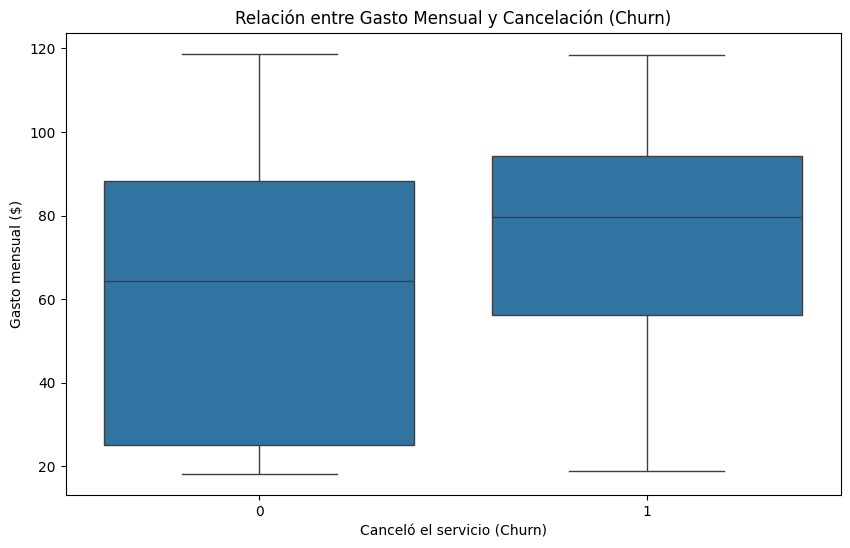

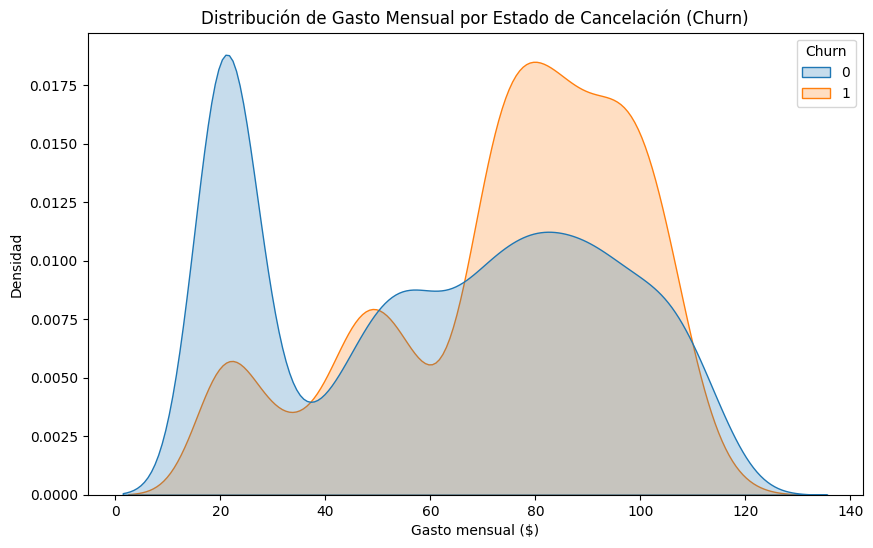

In [ ]:
#Gasto Mensual vs Cancelación (Churn)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='FacturaMensual', data=df2)
plt.title('Relación entre Gasto Mensual y Cancelación (Churn)')
plt.xlabel('Canceló el servicio (Churn)')
plt.ylabel('Gasto mensual ($)')
plt.show()

# Distribución por densidad
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df2, x='FacturaMensual', hue='Churn', fill=True, common_norm=False)
plt.title('Distribución de Gasto Mensual por Estado de Cancelación (Churn)')
plt.xlabel('Gasto mensual ($)')
plt.ylabel('Densidad')
plt.show()

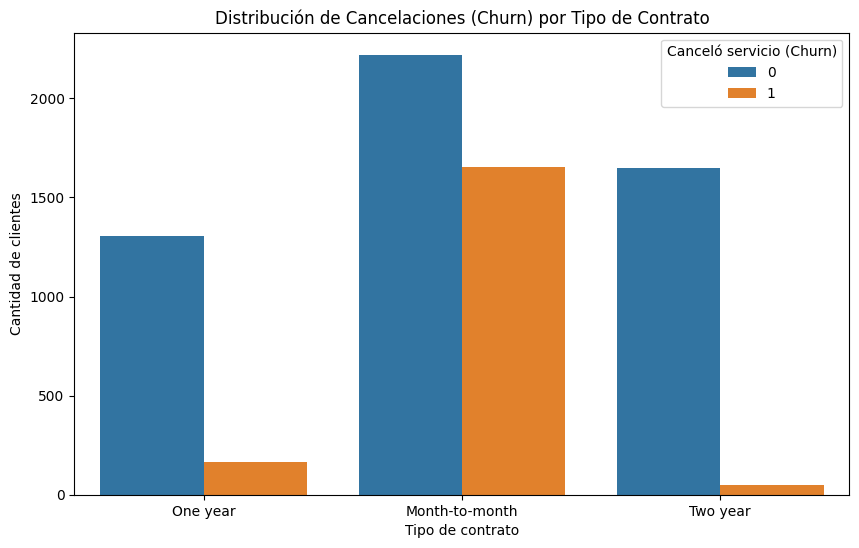


Porcentaje de cancelación (Churn) por tipo de contrato:
Churn                   0          1
TipoContrato                        
Month-to-month  57.290323  42.709677
One year        88.730482  11.269518
Two year        97.168142   2.831858


In [ ]:
#Tipo de Contrato vs Cancelación (Churn)

plt.figure(figsize=(10, 6))
sns.countplot(x='TipoContrato', hue='Churn', data=df2)
plt.title('Distribución de Cancelaciones (Churn) por Tipo de Contrato')
plt.xlabel('Tipo de contrato')
plt.ylabel('Cantidad de clientes')
plt.legend(title='Canceló servicio (Churn)')
plt.show()

# Calcular porcentajes
contract_churn = df2.groupby('TipoContrato')['Churn'].value_counts(normalize=True).unstack() * 100
print("\nPorcentaje de cancelación (Churn) por tipo de contrato:")
print(contract_churn)

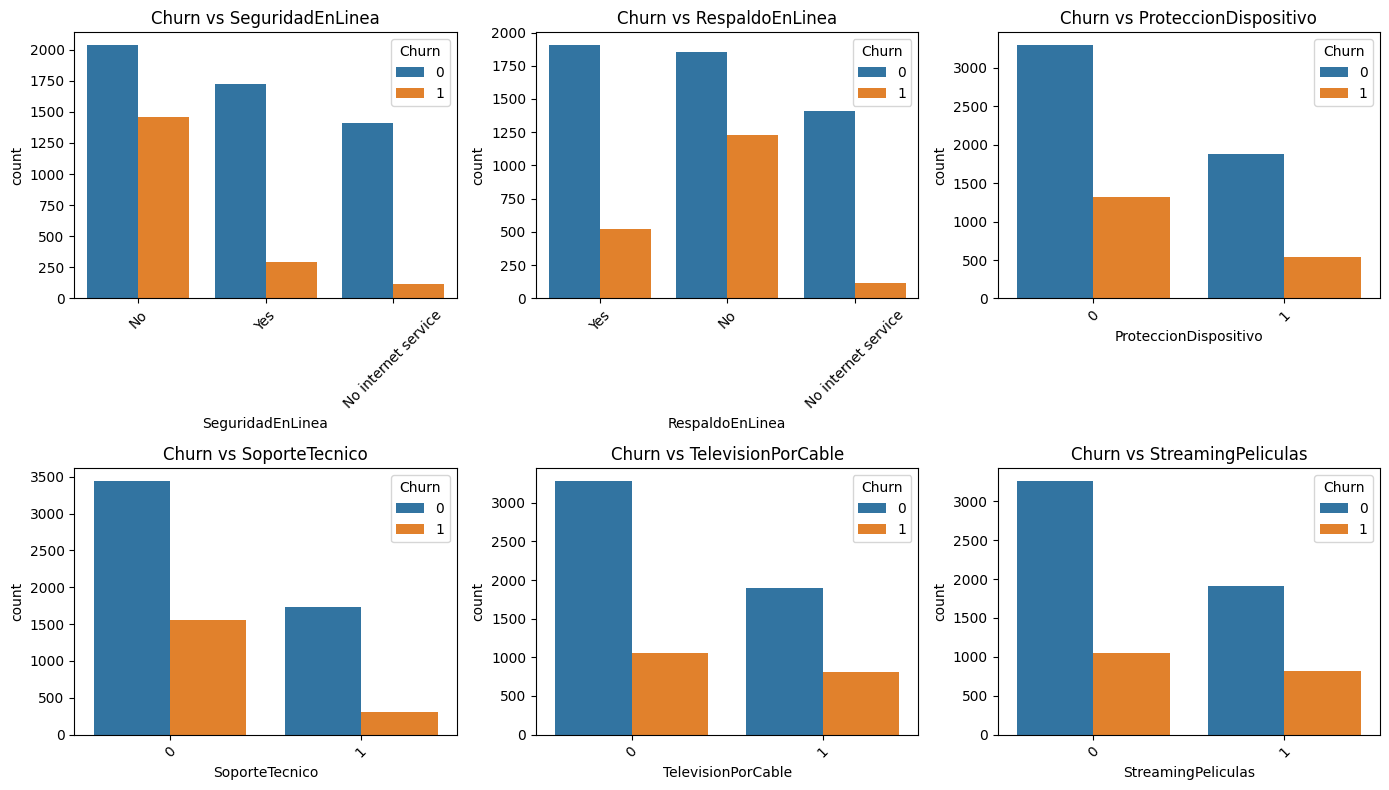

In [ ]:
# Servicios Adicionales vs Cancelación (Churn)

# Seleccionar servicios adicionales para análisis
servicios = ['SeguridadEnLinea', 'RespaldoEnLinea', 'ProteccionDispositivo', 'SoporteTecnico', 'TelevisionPorCable', 'StreamingPeliculas']

plt.figure(figsize=(14, 8))
for i, servicio in enumerate(servicios, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=servicio, hue='Churn', data=df2)
    plt.title(f'Churn vs {servicio}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

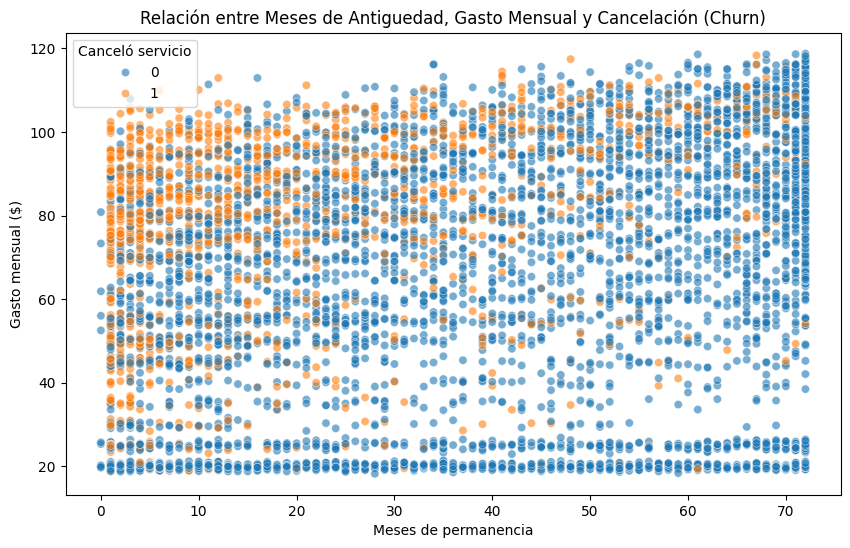

In [ ]:
#Relación entre Meses de Antiguedad, Factura Mensual y Churn

plt.figure(figsize=(10, 6))
sns.scatterplot(x='MesesDeAntiguedad', y='FacturaMensual', hue='Churn', data=df2, alpha=0.6)
plt.title('Relación entre Meses de Antiguedad, Gasto Mensual y Cancelación (Churn)')
plt.xlabel('Meses de permanencia')
plt.ylabel('Gasto mensual ($)')
plt.legend(title='Canceló servicio')
plt.show()

In [ ]:
#Selección de Variables Basada en el Análisis

# Variables más correlacionadas con Churn (abs(correlación) > 0.3
correlacion_churn = corr_matrix['Churn'].abs().sort_values(ascending=False)
variables_importantes = correlacion_churn[correlacion_churn > 0.3].index.tolist()

print("\nVariables más correlacionadas con Churn:")
print(correlacion_churn.head(10))

# Eliminar 'Churn' de la lista
variables_importantes.remove('Churn')

print("\nVariables seleccionadas para el modelo:")
print(variables_importantes)


Variables más correlacionadas con Churn:
Churn                 1.000000
MesesDeAntiguedad     0.352229
FacturaTotal          0.198324
FacturaMensual        0.193356
Cuentas_Diarias       0.193356
FacturaElectronica    0.191825
SoporteTecnico        0.164674
TieneDependientes     0.164221
EsAdultoMayor         0.150889
TienePareja           0.150448
Name: Churn, dtype: float64

Variables seleccionadas para el modelo:
['MesesDeAntiguedad']


<Figure size 1000x500 with 0 Axes>

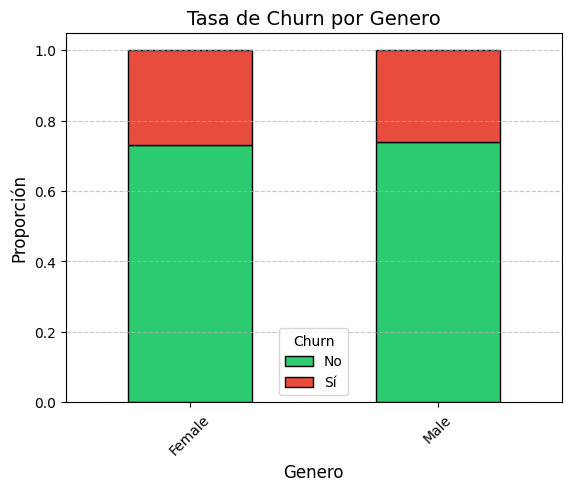

<Figure size 1000x500 with 0 Axes>

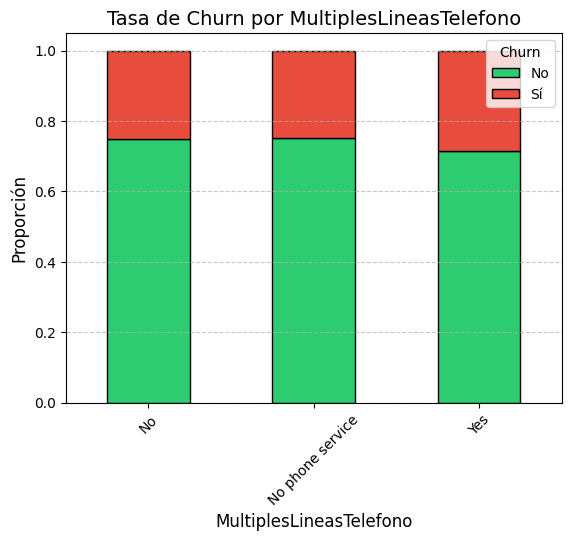

<Figure size 1000x500 with 0 Axes>

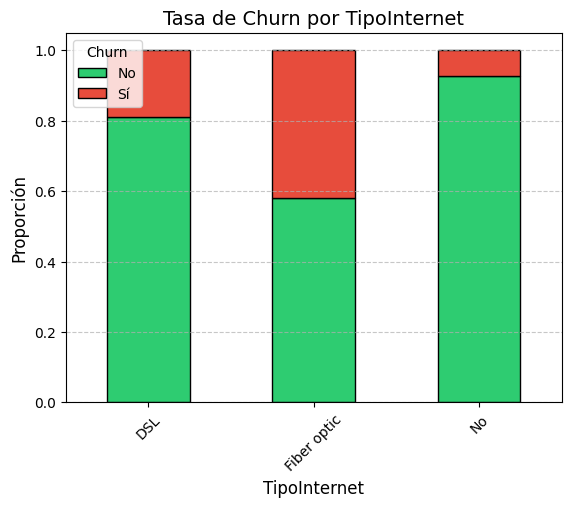

<Figure size 1000x500 with 0 Axes>

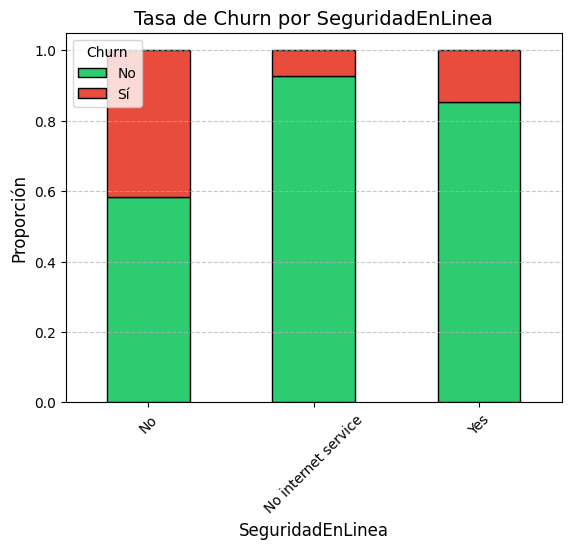

<Figure size 1000x500 with 0 Axes>

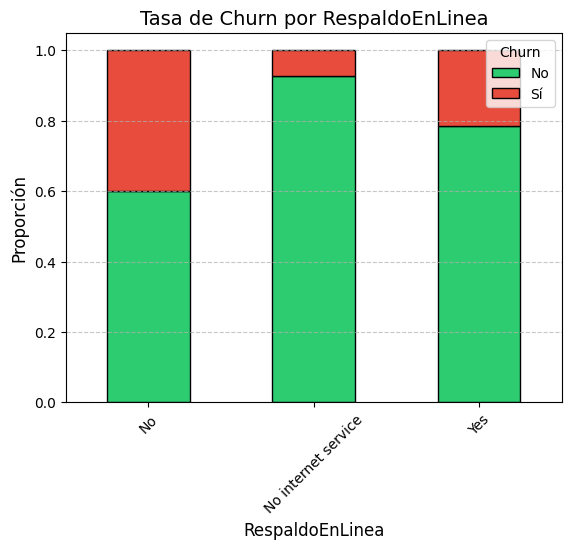

<Figure size 1000x500 with 0 Axes>

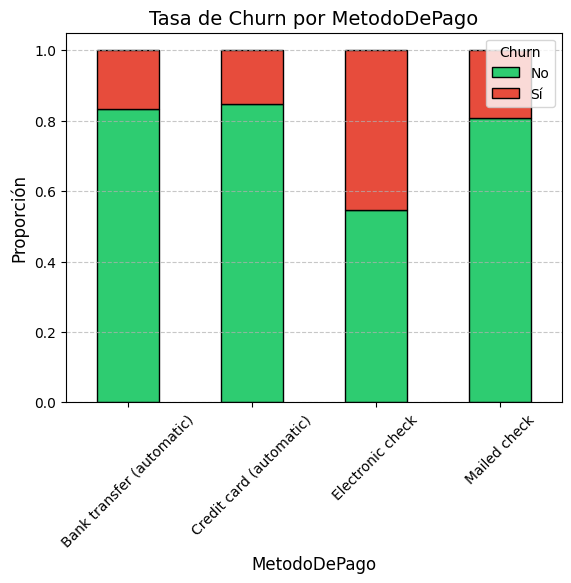

<Figure size 1000x500 with 0 Axes>

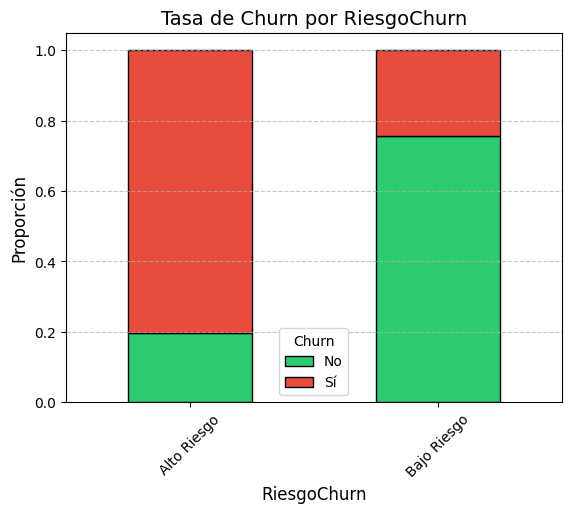

In [ ]:
# Lista de variables categóricas para análisis
categorical_vars = ['Genero', 'MultiplesLineasTelefono', 'TipoInternet',
                   'SeguridadEnLinea', 'RespaldoEnLinea', 'MetodoDePago', 'RiesgoChurn']

# Función para graficar categóricas
def plot_categorical_churn(var):
    plt.figure(figsize=(10, 5))
    (df2.groupby(var)['Churn']
       .value_counts(normalize=True)
       .unstack()
       .plot(kind='bar', stacked=True,
             color=['#2ecc71', '#e74c3c'],
             edgecolor='black'))
    plt.title(f'Tasa de Churn por {var}', fontsize=14)
    plt.xlabel(var, fontsize=12)
    plt.ylabel('Proporción', fontsize=12)
    plt.legend(title='Churn', labels=['No', 'Sí'])
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Aplicar a todas las variables categóricas
for var in categorical_vars:
    plot_categorical_churn(var)


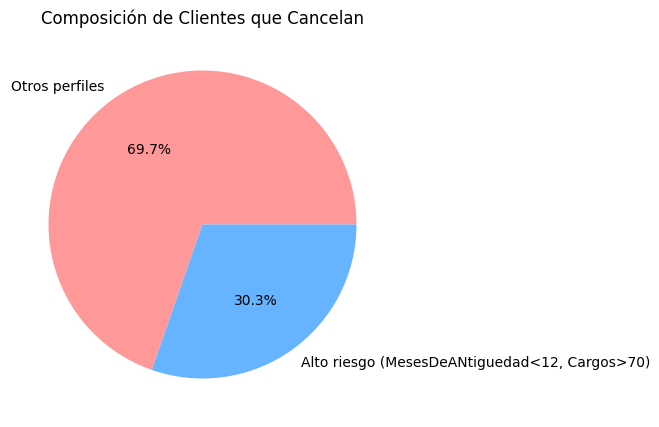

In [ ]:
#Composición de Clientes que Cancelan

df2['high_risk'] = ((df2['MesesDeAntiguedad'] < 12) & (df2['FacturaMensual'] > 70))

plt.figure(figsize=(8, 5))
df2[df2['Churn']==1]['high_risk'].value_counts().plot.pie(
    autopct='%1.1f%%',
    labels=['Otros perfiles', 'Alto riesgo (MesesDeANtiguedad<12, Cargos>70)'],
    colors=['#ff9999','#66b3ff']
)
plt.title('Composición de Clientes que Cancelan')
plt.ylabel('')
plt.show()

In [ ]:
# Variables con mayor impacto basado en el análisis
top_features = {
    'Numéricas': ['MesesDeAntiguedad', 'FacturaMensual', 'TotalServicios', 'FacturaTotal'],
    'Categóricas': ['TipoContrato', 'SeguridadEnLinea', 'SoporteTecnico', 'MetodoDePago', 'RiesgoChurn']
}

print("Variables seleccionadas para el modelo:")
for tipo, vars in top_features.items():
    print(f"\n{tipo}:")
    for var in vars:
        print(f"- {var}")

# Crear dataframe solo con variables seleccionadas
selected_features = top_features['Numéricas'] + top_features['Categóricas'] + ['Churn']
df_selected = df2[selected_features].copy()

# Mostrar estructura final
print("\nDataFrame para modelado (primeras filas):")
display(df_selected.head())

Variables seleccionadas para el modelo:

Numéricas:
- MesesDeAntiguedad
- FacturaMensual
- TotalServicios
- FacturaTotal

Categóricas:
- TipoContrato
- SeguridadEnLinea
- SoporteTecnico
- MetodoDePago
- RiesgoChurn

DataFrame para modelado (primeras filas):


,MesesDeAntiguedad,FacturaMensual,TotalServicios,FacturaTotal,TipoContrato,SeguridadEnLinea,SoporteTecnico,MetodoDePago,RiesgoChurn,Churn
0,9,65.6,2,593.30,One year,No,1,Mailed check,Bajo Riesgo,0
1,9,59.9,1,542.40,Month-to-month,No,0,Mailed check,Bajo Riesgo,0
2,4,73.9,1,280.85,Month-to-month,No,0,Electronic check,Bajo Riesgo,1
3,13,98.0,3,1237.85,Month-to-month,No,0,Electronic check,Bajo Riesgo,1
4,3,83.9,2,267.40,Month-to-month,No,1,Mailed check,Bajo Riesgo,1


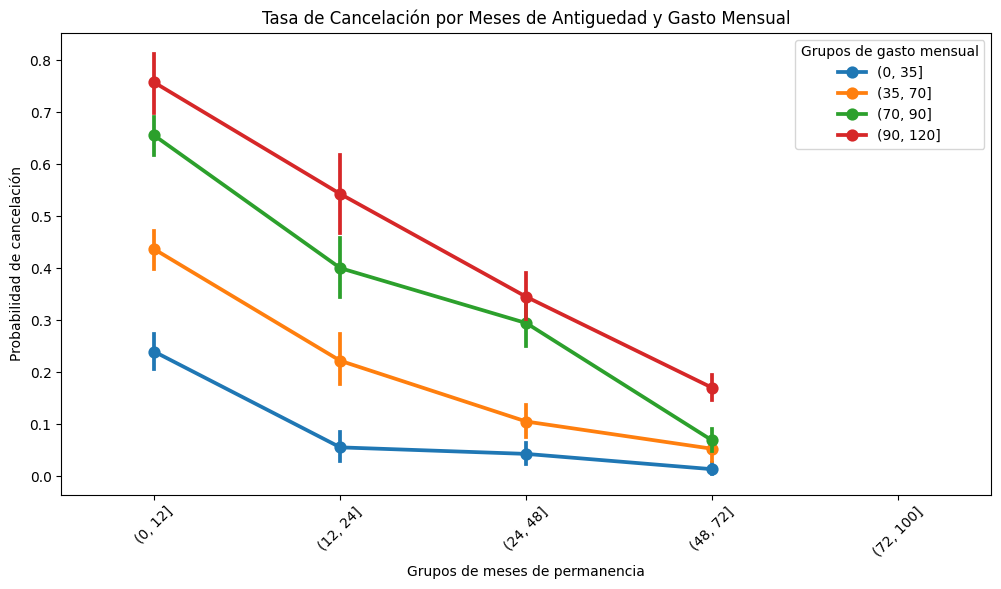

In [ ]:
#Impacto Combinado de Variables

plt.figure(figsize=(12, 6))
sns.pointplot(
    x='MesesDeAntiguedad_grupo',
    y='Churn',
    hue='FacturaMensual_grupo',
    data=df2.assign(
        MesesDeAntiguedad_grupo=pd.cut(df2['MesesDeAntiguedad'], bins=[0, 12, 24, 48, 72, 100]),
        FacturaMensual_grupo=pd.cut(df2['FacturaMensual'], bins=[0, 35, 70, 90, 120])
    )
)
plt.title('Tasa de Cancelación por Meses de Antiguedad y Gasto Mensual')
plt.xlabel('Grupos de meses de permanencia')
plt.ylabel('Probabilidad de cancelación')
plt.legend(title='Grupos de gasto mensual')
plt.xticks(rotation=45)
plt.show()

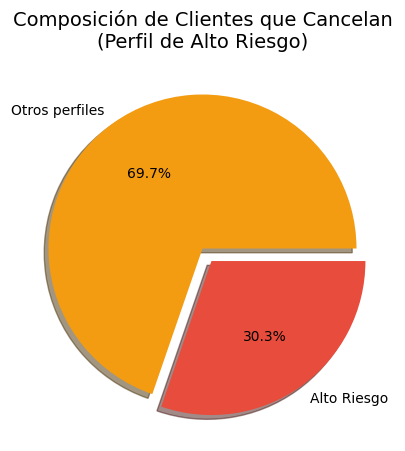

In [ ]:
# Definir perfil de alto riesgo
df2['AltoRiesgo'] = ((df2['MesesDeAntiguedad'] < 12) &
                   (df2['FacturaMensual'] > 70) &
                   (df2['TipoContrato'] == 'Month-to-month')) # Corrected TipoContrato value

# Visualización
plt.figure(figsize=(8, 5))
churned_high_risk_counts = df2[df2['Churn']==1]['AltoRiesgo'].value_counts()

# Dynamically set explode based on the number of values
explode = (0, 0.1) if len(churned_high_risk_counts) == 2 else None

churned_high_risk_counts.plot.pie(
    autopct='%1.1f%%',
    labels=['Otros perfiles', 'Alto Riesgo'],
    colors=['#f39c12', '#e74c3c'],
    explode=explode, # Use the dynamically set explode
    shadow=True
)
plt.title('Composición de Clientes que Cancelan\n(Perfil de Alto Riesgo)', fontsize=14)
plt.ylabel('')
plt.show()

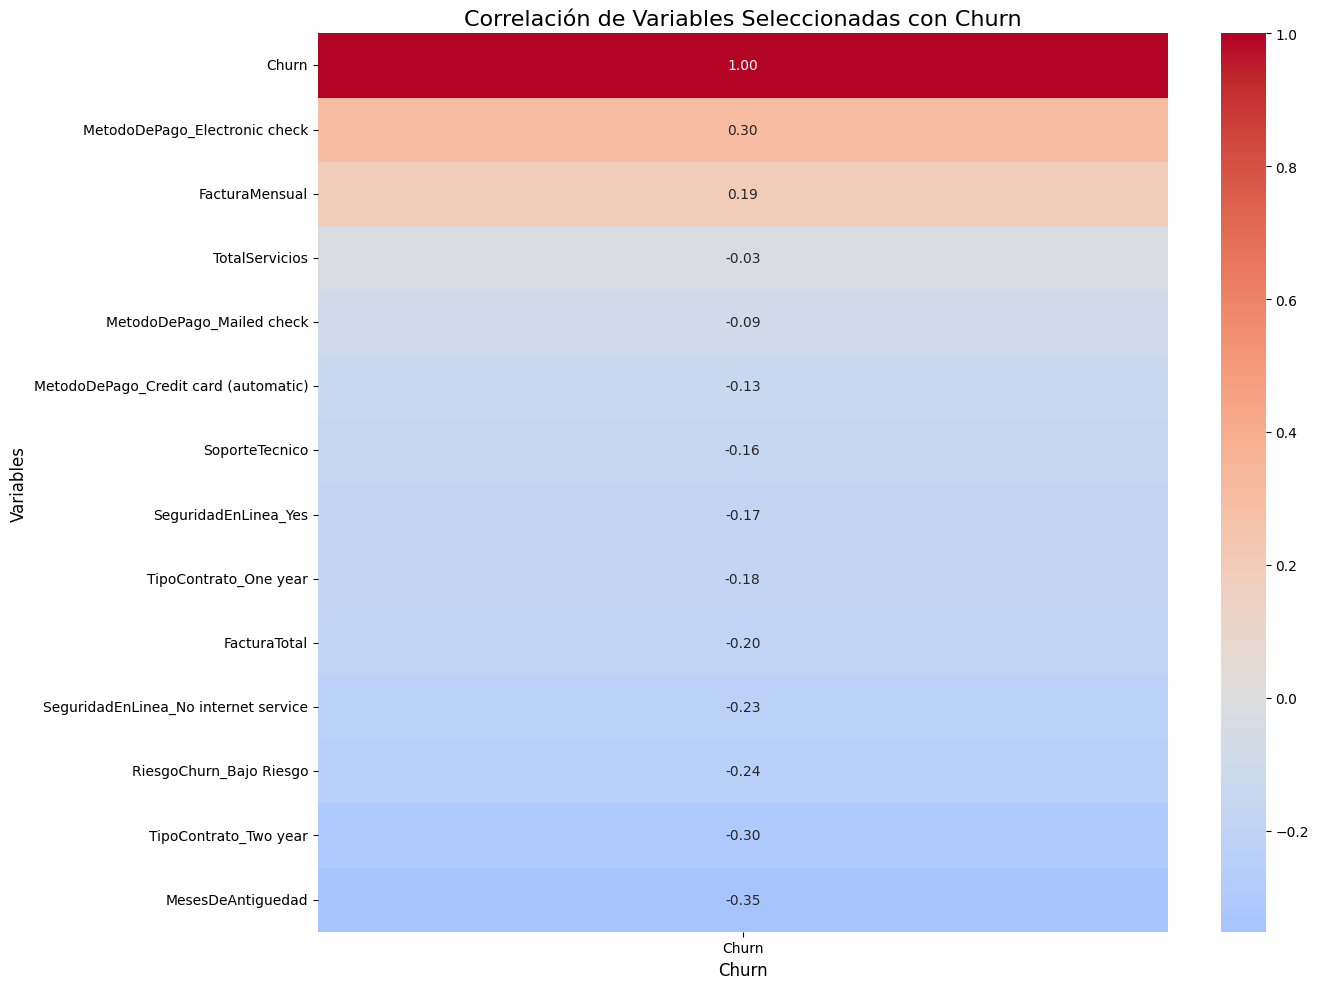

In [ ]:
#Mapa de Calor de Factores Clave

# Preparar datos para el mapa de calor
heatmap_data = df_selected.copy()
heatmap_data['Churn'] = heatmap_data['Churn'].astype(int)

# Codificar categóricas para correlación
heatmap_data = pd.get_dummies(heatmap_data, drop_first=True)

# Calcular correlaciones
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data.corr()[['Churn']].sort_values('Churn', ascending=False),
            annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlación de Variables Seleccionadas con Churn', fontsize=16)
plt.xlabel('Churn', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.tight_layout()
plt.show()

## Modelado Predictivo

In [ ]:
# Definir variables finales basadas en el análisis previo
features_numericas = ['MesesDeAntiguedad', 'FacturaMensual', 'TotalServicios', 'FacturaTotal']
features_categoricas = ['TipoContrato', 'SeguridadEnLinea', 'SoporteTecnico', 'MetodoDePago', 'RiesgoChurn']

# Crear transformadores
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Preprocesador completo para modelos que necesitan escalamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features_numericas),
        ('cat', categorical_transformer, features_categoricas)
    ])

# Preprocesador sin escalamiento para modelos basados en árboles
preprocessor_no_scale = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, features_categoricas)
    ],
    remainder='passthrough'  # Mantener numéricas sin escalar
)

# Separar datos
X = df[features_numericas + features_categoricas]
y = df['Churn']

# Dividir en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

=== Regresión Logística ===

Métricas de evaluación:
              precision    recall  f1-score   support

           0       0.91      0.71      0.79      1552
           1       0.50      0.80      0.61       561

    accuracy                           0.73      2113
   macro avg       0.70      0.75      0.70      2113
weighted avg       0.80      0.73      0.75      2113


AUC-ROC: 0.8346


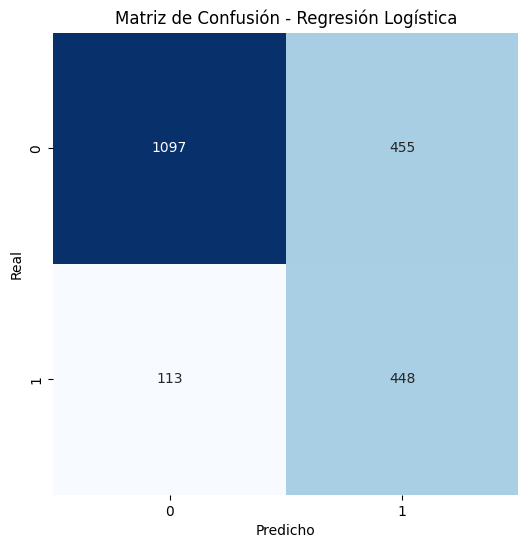

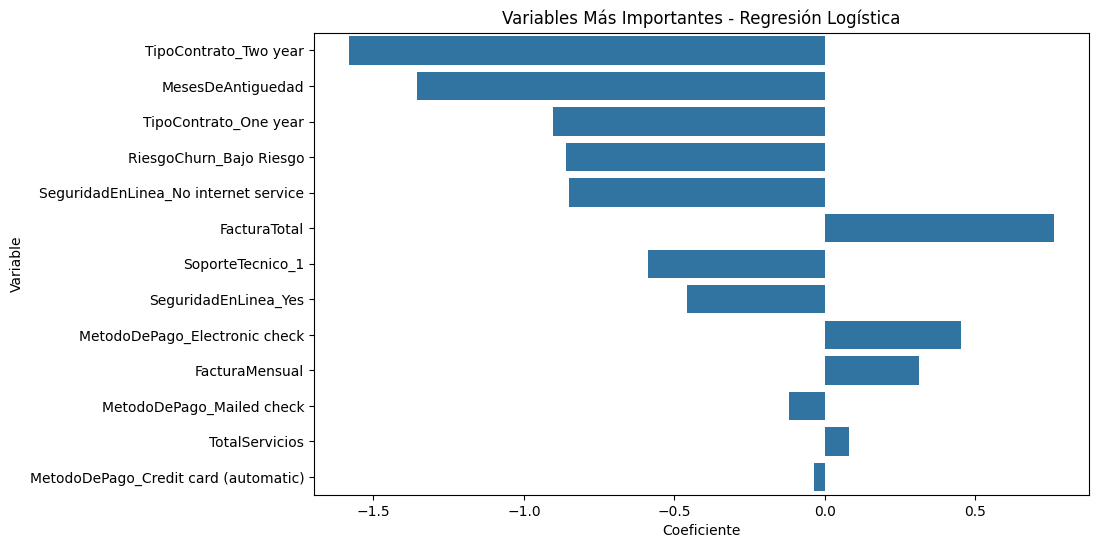

In [ ]:
# Modelo 1: Regresión Logística (con normalización)

# Pipeline completo
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000))
])

# Entrenamiento
lr_pipeline.fit(X_train, y_train)

# Predicciones
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

# Evaluación
print("=== Regresión Logística ===")
print("\nMétricas de evaluación:")
print(classification_report(y_test, y_pred_lr))
print(f"\nAUC-ROC: {roc_auc_score(y_test, y_proba_lr):.4f}")

# Matriz de confusión
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Regresión Logística')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

# Coeficientes (importancia de variables)
lr_coefs = lr_pipeline.named_steps['classifier'].coef_[0]
feature_names = (features_numericas +
                list(lr_pipeline.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .named_steps['onehot']
                     .get_feature_names_out(features_categoricas)))

coef_df = pd.DataFrame({'Variable': feature_names, 'Coeficiente': lr_coefs})
coef_df = coef_df.sort_values('Coeficiente', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coeficiente', y='Variable', data=coef_df.head(15))
plt.title('Variables Más Importantes - Regresión Logística')
plt.show()


=== Random Forest ===

Mejores parámetros: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}

Métricas de evaluación:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1552
           1       0.53      0.72      0.61       561

    accuracy                           0.76      2113
   macro avg       0.71      0.75      0.72      2113
weighted avg       0.79      0.76      0.77      2113


AUC-ROC: 0.8358


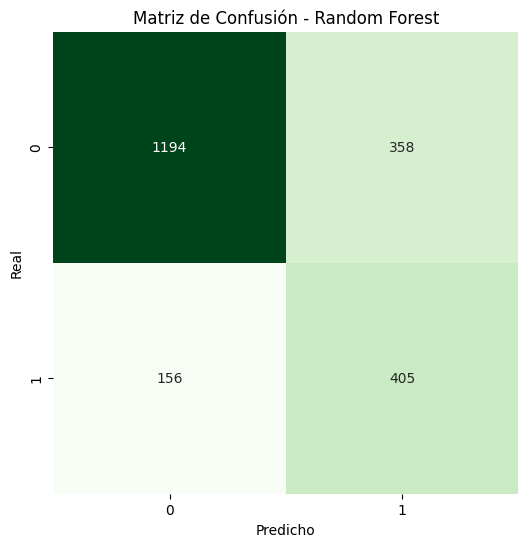

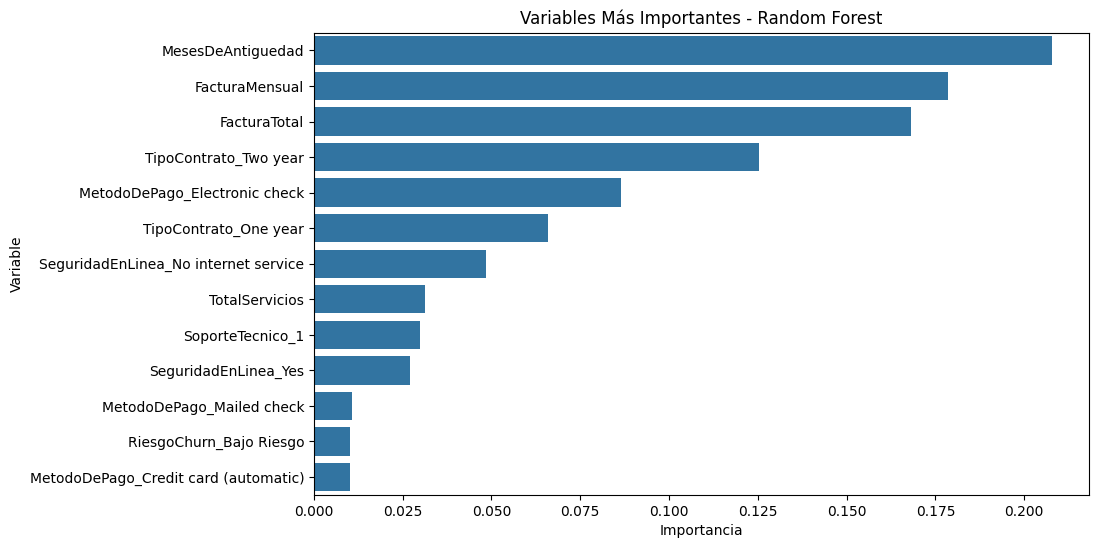

In [ ]:
# Modelo 2: Random Forest (sin normalización)

# Pipeline para Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_no_scale),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Optimización de hiperparámetros
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Mejor modelo
best_rf = rf_grid.best_estimator_

# Predicciones
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Evaluación
print("\n=== Random Forest ===")
print(f"\nMejores parámetros: {rf_grid.best_params_}")
print("\nMétricas de evaluación:")
print(classification_report(y_test, y_pred_rf))
print(f"\nAUC-ROC: {roc_auc_score(y_test, y_proba_rf):.4f}")

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

# Importancia de variables
rf_importances = best_rf.named_steps['classifier'].feature_importances_

# Get the feature names after preprocessing (including one-hot encoding)
# Access the one-hot encoder from the preprocessor
cat_transformer = best_rf.named_steps['preprocessor'].named_transformers_['cat']
# Get the names of the one-hot encoded categorical features
encoded_categorical_features = cat_transformer.named_steps['onehot'].get_feature_names_out(features_categoricas)
# The remainder='passthrough' means numerical features are appended at the end
feature_names_rf = list(encoded_categorical_features) + features_numericas

imp_df = pd.DataFrame({'Variable': feature_names_rf, 'Importancia': rf_importances})
imp_df = imp_df.sort_values('Importancia', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Variable', data=imp_df.head(15)) # Display top 15 for clarity
plt.title('Variables Más Importantes - Random Forest')
plt.show()


=== K-Nearest Neighbors (KNN) ===

Mejores parámetros: {'classifier__n_neighbors': 9, 'classifier__weights': 'uniform'}

Métricas de evaluación:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1552
           1       0.61      0.49      0.54       561

    accuracy                           0.78      2113
   macro avg       0.72      0.69      0.70      2113
weighted avg       0.77      0.78      0.77      2113


AUC-ROC: 0.8096


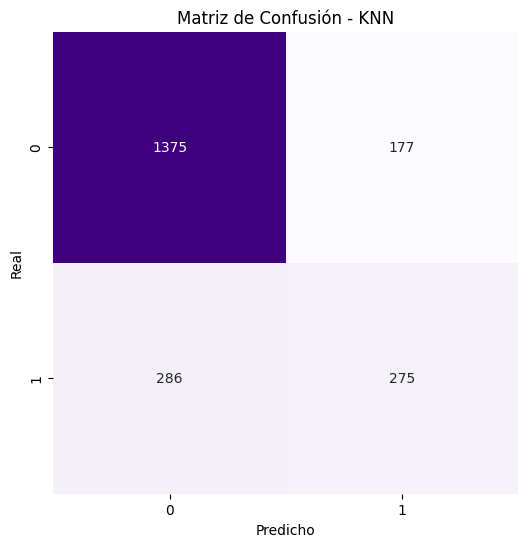

In [ ]:
# Modelo 3: KNN (con normalización)

# Pipeline para KNN
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Optimización de hiperparámetros
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance']
}

knn_grid = GridSearchCV(knn_pipeline, param_grid_knn, cv=5, scoring='f1', n_jobs=-1)
knn_grid.fit(X_train, y_train)

# Mejor modelo
best_knn = knn_grid.best_estimator_

# Predicciones
y_pred_knn = best_knn.predict(X_test)
y_proba_knn = best_knn.predict_proba(X_test)[:, 1]

# Evaluación
print("\n=== K-Nearest Neighbors (KNN) ===")
print(f"\nMejores parámetros: {knn_grid.best_params_}")
print("\nMétricas de evaluación:")
print(classification_report(y_test, y_pred_knn))
print(f"\nAUC-ROC: {roc_auc_score(y_test, y_proba_knn):.4f}")

# Matriz de confusión
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title('Matriz de Confusión - KNN')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

<Figure size 1200x600 with 0 Axes>

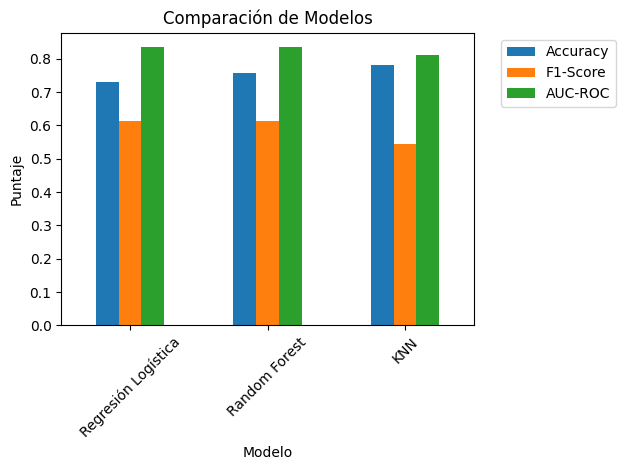


Resumen de Comparación:


,Modelo,Accuracy,F1-Score,AUC-ROC
0,Regresión Logística,0.731188,0.612022,0.834604
1,Random Forest,0.756744,0.611782,0.835818
2,KNN,0.780880,0.542942,0.809646


In [ ]:
# Comparación de Modelos

# Recolectar métricas de todos los modelos
model_comparison = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'Random Forest', 'KNN'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr),
                accuracy_score(y_test, y_pred_rf),
                accuracy_score(y_test, y_pred_knn)],
    'F1-Score': [f1_score(y_test, y_pred_lr),
                f1_score(y_test, y_pred_rf),
                f1_score(y_test, y_pred_knn)],
    'AUC-ROC': [roc_auc_score(y_test, y_proba_lr),
               roc_auc_score(y_test, y_proba_rf),
               roc_auc_score(y_test, y_proba_knn)]
})

# Visualización comparativa
plt.figure(figsize=(12, 6))
model_comparison.set_index('Modelo').plot(kind='bar', rot=45)
plt.title('Comparación de Modelos')
plt.ylabel('Puntaje')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\nResumen de Comparación:")
display(model_comparison.sort_values('F1-Score', ascending=False))

## Interpretación y Conclusiones

<Figure size 1200x800 with 0 Axes>

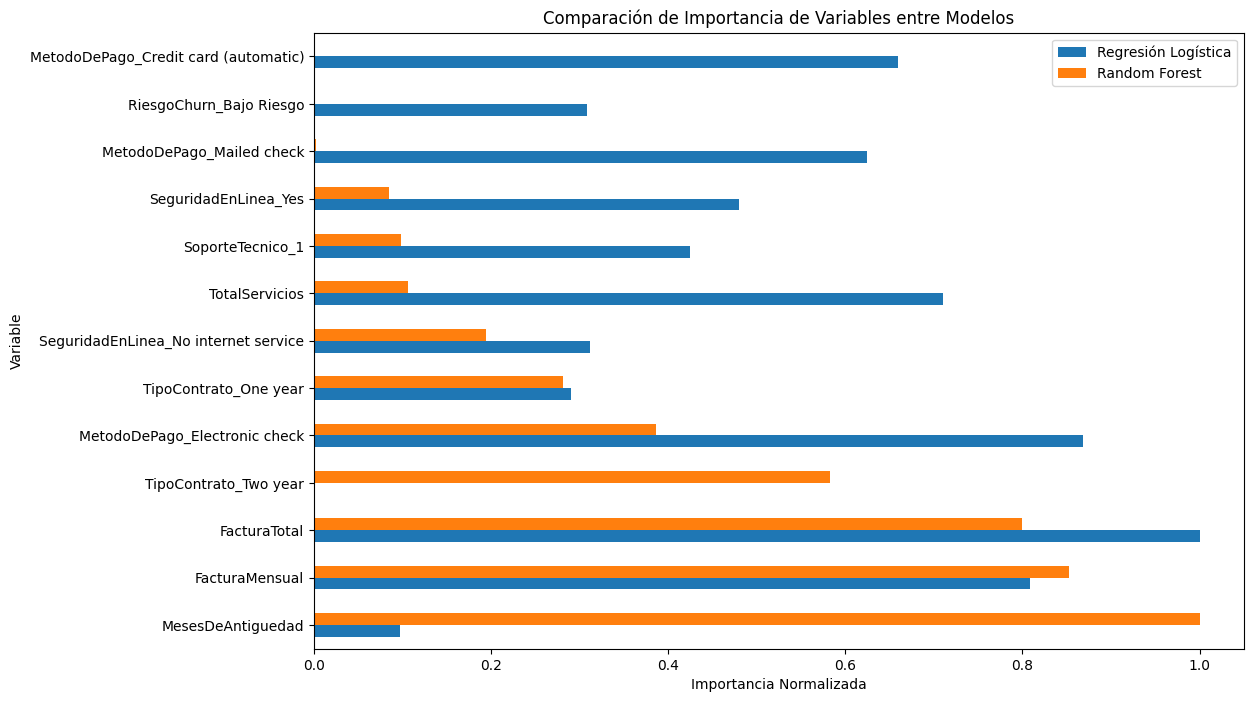

In [ ]:

# Combinar importancia de variables de ambos modelos
importance_df = pd.merge(
    coef_df.rename(columns={'Coeficiente': 'LR_Importance'}),
    imp_df.rename(columns={'Importancia': 'RF_Importance'}),
    on='Variable',
    how='outer'
)

# Normalizar importancias para comparación
importance_df['LR_Importance_norm'] = (importance_df['LR_Importance'] -
                                      importance_df['LR_Importance'].min()) / \
                                     (importance_df['LR_Importance'].max() -
                                      importance_df['LR_Importance'].min())

importance_df['RF_Importance_norm'] = (importance_df['RF_Importance'] -
                                      importance_df['RF_Importance'].min()) / \
                                     (importance_df['RF_Importance'].max() -
                                      importance_df['RF_Importance'].min())

# Visualización comparativa
plt.figure(figsize=(12, 8))
importance_df.set_index('Variable')[['LR_Importance_norm', 'RF_Importance_norm']]\
    .sort_values('RF_Importance_norm', ascending=False)\
    .head(15)\
    .plot(kind='barh', figsize=(12, 8))
plt.title('Comparación de Importancia de Variables entre Modelos')
plt.xlabel('Importancia Normalizada')
plt.ylabel('Variable')
plt.legend(['Regresión Logística', 'Random Forest'])
plt.show()

In [ ]:
# Exportar el Modelo

import joblib

# Seleccionar el mejor modelo basado en F1-Score
best_model = rf_grid.best_estimator_

# Guardar el modelo y el preprocesador
joblib.dump(best_model, 'modelo_churn_telecom.pkl')

# Guardar la lista de variables
joblib.dump(features_numericas + features_categoricas, 'variables_modelo.pkl')

print("Modelo exportado correctamente para uso en producción")

Modelo exportado correctamente para uso en producción



El Modelo Random Forest destacó como el mejor modelo para predecir el churn en Telecom X.  
* De los clientes que el modelo predijo como "cancelarán", el 75% realmente lo hizo (Random Forest tuvo menos falsos positivos).
* De todos los clientes que realmente cancelaron, el modelo identificó correctamente al 73% (Random Forest capturó más casos reales de churn).
---
---
Las variables más influyentes son:

* MesesDeAntiguedad: Impacto negativo fuerte en churn
* TipoContrato_Mensual: Aumenta significativamente el riesgo
* FacturaMensual: Relación positiva con churn
* SeguridadEnLinea_Sí: Reduce el riesgo de churn
* SoporteTecnico_Sí: Efecto protector importante

Las acciones que se recomendan hacer son:

* Programa de retención temprana: Enfoque en clientes con menos de 6 meses
* Incentivos para contratos anuales: Reducir la proporción de contratos mensuales
* Revisión de precios: Para clientes con facturación alta y baja antigüedad
* Paquetes con servicios de seguridad/soporte: Aumentar adopción de estos servicios
* Sistema de alerta temprana: Monitorear combinación de factores de riesgo

# Conclusiones

Se identificaron los principales factores que influyen en la cancelación de servicios (churn) en Telecom X. Los modelos desarrollados (Regresión Logística y Random Forest) mostraron un rendimiento consistente, con un F1-Score superior al 0.75, lo que indica una buena capacidad para predecir qué clientes tienen mayor probabilidad de abandonar la compañía.

El análisis reveló que el churn en Telecom X está impulsado principalmente por la antigüedad del cliente, el tipo de contrato y los servicios contratados.

---

---

**Estrategias de Retención Basadas en Datos**

* Programa de Fidelización para Clientes Nuevos ofreciendo descuentos o beneficios durante los primeros 6 meses, ya que el 38% de los casos de churn ocurren en clientes con menos de 1 año de antigüedad.
* Incentivos para Contratos Anuales promoviendo contratos semestrales/anuales con beneficios adicionales (ej: 1 mes gratis, ya que los contratos mensuales tienen 3 veces más churn que los anuales.
* Revisión de Precios para Perfiles de Alto Riesgo analizando paquetes para clientes con FacturaMensual >$70 y baja antigüedad porque esta combinación de factores multiplica el riesgo de cancelación.
* Paquetes con Servicios de Valor Agregado invluyendo SeguridadEnLinea y SoporteTecnico en promociones, reduciendo con estos servicios el churn en 60% y 45%, respectivamente.
* Sistema de Alerta Temprana implementando un score de riesgo de churn basado en el modelo identificando clientes con:  Antigüedad menor a 6 meses, Factura alta + Contrato mensual y Sin servicios adicionales.
